### Code to aggregate NASA LIS data to GRACE mascons

### Load the packages

In [3]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data
import os
import sys
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
import scipy.optimize
from scipy import stats
import geopandas as gpd
import pandas as pd
import s3fs
import salem
from PyAstronomy import pyasl
import xarray as xr
from datetime import datetime, timedelta
import boto3
import botocore
import dask.array as da
import metpy
from pyproj import Proj, transform
#from dask import compute
from dask.diagnostics import ProgressBar
from dask import compute
    
matplotlib.style.use('ggplot')

from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, trend_analysis, get_cmwe_trend_analysis, select_mascons, aggregate_mascons)

import warnings
warnings.filterwarnings('ignore')

/home/yingjung_cd/miniconda3/envs/himat/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/yingjung_cd/miniconda3/envs/himat/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Open the LIS data

In [6]:
datadir = '/mnt/c/Users/HCD/UW_work/git/HiMAT/files/LIS/new/original_NASA/original_monthly/'

In [7]:
dgws = xr.open_mfdataset(datadir+'*.nc')*0.1

In [9]:
dgws_t=dgws

In [24]:
print(dgws)

<xarray.Dataset>
Dimensions:     (east_west: 137, north_south: 81, time: 180)
Coordinates:
  * time        (time) datetime64[ns] 2003-02-01 2003-03-01 ... 2018-01-01
    latitude    (north_south, east_west) float64 ...
    longitude   (north_south, east_west) float64 ...
Dimensions without coordinates: east_west, north_south
Data variables:
    Qsm_tavg    (time, north_south, east_west) float64 0.0 0.0 0.0 ... 0.0 0.0
    Rainf_tavg  (time, north_south, east_west) float64 0.0 0.0 ... 0.001204
    Qs_tavg     (time, north_south, east_west) float64 0.0 0.0 ... 0.0001655
    Snowf_tavg  (time, north_south, east_west) float64 0.0 0.0 ... 0.1883 0.1906
    Qsb_tavg    (time, north_south, east_west) float64 0.0 0.0 ... 0.03219
    Evap_tavg   (time, north_south, east_west) float64 0.0 0.0 ... 0.02556
    TWS_tavg    (time, north_south, east_west) float32 0.0 0.0 ... 15336.175
    GWS_tavg    (time, north_south, east_west) float64 0.0 0.0 ... 1.236e+09


In [16]:
datadir2 = '/mnt/c/Users/HCD/UW_work/git/HiMAT/files/LIS/files/'

In [21]:
dgws1=xr.open_dataset(datadir2+'LISMonthly_new.nc')*0.1

### Create a corrected lat, long format

In [22]:
lat=dgws1.latitude.drop('longitude')
lat=lat[:,-1]
lat=lat.rename({'north_south':'lat'})

In [23]:
long=dgws1.longitude.drop('latitude')
long=long[-1,:]
long=long.rename({'east_west':'long'})

### Drop the extra coordinates and rename dimensions

In [27]:
dgws=dgws.drop('latitude')

In [28]:
dgws=dgws.drop('longitude')

In [29]:
dgws = dgws.rename({'north_south':'lat','east_west':'long'})
LIS = dgws.assign_coords(lat=lat,long=long, time=dgws.coords['time'])

In [30]:
to_drop = [dim for dim in LIS.data_vars if LIS[dim].dims != ('time', 'lat', 'long')] 
LIS = LIS.drop(to_drop)

In [32]:
LIS=LIS.drop('latitude')

In [33]:
LIS=LIS.drop('longitude')

In [34]:
print(LIS)

<xarray.Dataset>
Dimensions:     (lat: 81, long: 137, time: 180)
Coordinates:
  * time        (time) datetime64[ns] 2003-02-01 2003-03-01 ... 2018-01-01
  * lat         (lat) float64 20.88 21.12 21.38 21.62 ... 40.38 40.62 40.88
  * long        (long) float64 66.88 67.12 67.38 67.62 ... 100.4 100.6 100.9
Data variables:
    Qsm_tavg    (time, lat, long) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Rainf_tavg  (time, lat, long) float64 0.0 0.0 0.0 ... 0.003302 0.001204
    Qs_tavg     (time, lat, long) float64 0.0 0.0 0.0 ... 0.0007811 0.0001655
    Snowf_tavg  (time, lat, long) float64 0.0 0.0 0.0 ... 0.1879 0.1883 0.1906
    Qsb_tavg    (time, lat, long) float64 0.0 0.0 0.0 ... 0.0294 0.03036 0.03219
    Evap_tavg   (time, lat, long) float64 0.0 0.0 0.0 ... 0.02615 0.02556
    TWS_tavg    (time, lat, long) float32 0.0 0.0 0.0 ... 15347.929 15336.175
    GWS_tavg    (time, lat, long) float64 0.0 0.0 0.0 ... 1.235e+09 1.236e+09


### Extract the lat, lon from data variables

In [11]:
lat_coords=dgws_t.lat[-1,:,-1]
lon_coords=dgws_t.lon[-1,-1,:]
#lon_coords[1] = lon_coords[0] + 0.775 # Filling in missing value
lat_coords = lat_coords.rename({'north_south':'lat'})
lon_coords = lon_coords.rename({'east_west':'long'})

In [24]:
#dgws_t = dgws_t.drop(['lat', 'lon'])
#dgws_t = dgws_t.rename({'north_south':'lat','east_west':'long'})
LIS_t = dgws_t.assign_coords(lat=lat,long=long, time=dgws_t.coords['time'])
# Drop arrays with dimension greater than 3
to_drop = [dim for dim in LIS_t.data_vars if LIS_t[dim].dims != ('time', 'lat', 'long')] 
LIS_t = LIS_t.drop(to_drop)

In [25]:
print(LIS_t)

<xarray.Dataset>
Dimensions:           (lat: 81, long: 137, time: 5480)
Coordinates:
  * time              (time) datetime64[ns] 2003-02-01 2003-02-02 ... 2018-02-01
    latitude          (lat) float64 ...
    longitude         (long) float64 ...
  * lat               (lat) float64 20.88 21.12 21.38 ... 40.38 40.62 40.88
  * long              (long) float64 66.88 67.12 67.38 ... 100.4 100.6 100.9
Data variables:
    Swnet_tavg        (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Lwnet_tavg        (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Qle_tavg          (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Qh_tavg           (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Qg_tavg           (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Snowf_tavg        (time, lat, long) float32 d

In [27]:
LIS=LIS_t.drop('latitude')

In [28]:
LIS=LIS.drop('longitude')

In [29]:
print(LIS)

<xarray.Dataset>
Dimensions:           (lat: 81, long: 137, time: 5480)
Coordinates:
  * time              (time) datetime64[ns] 2003-02-01 2003-02-02 ... 2018-02-01
  * lat               (lat) float64 20.88 21.12 21.38 ... 40.38 40.62 40.88
  * long              (long) float64 66.88 67.12 67.38 ... 100.4 100.6 100.9
Data variables:
    Swnet_tavg        (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Lwnet_tavg        (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Qle_tavg          (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Qh_tavg           (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Qg_tavg           (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Snowf_tavg        (time, lat, long) float32 dask.array<shape=(5480, 81, 137), chunksize=(28, 81, 137)>
    Rainf_tavg        (

In [38]:
#LIS.to_netcdf('LISmonthly_rfok.nc')

### Load well spatial domain and drop all the other data variable 

In [30]:
LISr=LIS.sel(long=slice(65,100), lat=slice(21, 35))

In [31]:
LISr=LISr[['GWS_tavg']]

In [32]:
print(LISr)

<xarray.Dataset>
Dimensions:   (lat: 56, long: 133, time: 5480)
Coordinates:
  * lat       (lat) float64 21.12 21.38 21.62 21.88 ... 34.12 34.38 34.62 34.88
  * time      (time) datetime64[ns] 2003-02-01 2003-02-02 ... 2018-02-01
  * long      (long) float64 66.88 67.12 67.38 67.62 ... 99.12 99.38 99.62 99.88
Data variables:
    GWS_tavg  (time, lat, long) float32 dask.array<shape=(5480, 56, 133), chunksize=(28, 56, 133)>
Attributes:
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    SOIL_LAYER_THICKNESSES:  [0.1 0.3 0.6 1. ]
    title:                   LIS land surface model output
    institution:             NASA GSFC
    source:                  
    history:                 created on date: 2018-12-07T18:48:14.415
    references:              Kumar_etal_EMS_2006, Peters-Lidard_etal_ISSE_2007
    conventions:             CF-1.6
    comment:                 website: http://lis.gsfc.nasa.gov/
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CO

### LIS gws anomaly

In [33]:
LGWS_mean = LISr.groupby('time.month').mean('time')
LISa = LISr.groupby('time.month') - LGWS_mean

In [34]:
print(LISa)

<xarray.Dataset>
Dimensions:   (lat: 56, long: 133, time: 5480)
Coordinates:
  * lat       (lat) float64 21.12 21.38 21.62 21.88 ... 34.12 34.38 34.62 34.88
  * long      (long) float64 66.88 67.12 67.38 67.62 ... 99.12 99.38 99.62 99.88
  * time      (time) datetime64[ns] 2003-02-01 2003-02-02 ... 2018-02-01
    month     (time) int64 2 2 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1 1 2
Data variables:
    GWS_tavg  (time, lat, long) float32 dask.array<shape=(5480, 56, 133), chunksize=(28, 56, 133)>


In [35]:
fp="/mnt/c/Users/HCD/UW_work/git/HiMAT/files/WBM/Watershed_boundaries/dugwells_districts_d.shp"

In [36]:
well_d=gpd.read_file(fp)
shdf = salem.read_shapefile(fp)

### Download the GRACE data from S3 bucket

In [38]:
fileName = '../../files/GRACE/GSFC.glb.200301_201607_v02.4-ICE6G.h5'
grace_file = os.path.abspath(fileName)
f = extract_grace(grace_file)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1, 148), type "<f8">
<HDF5 dataset "n_ref_days_window": shape (

In [39]:
mascon = f['mascon']
soln = f['solution']
time = f['time']

mascon_gdf = get_mascon_gdf(mascon)
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


### Clip the GRACE mascons to the domain of GWA

In [40]:
masked_gdf4 = select_mascons(LISa, mascon_gdf)

In [46]:
#print(masked_gdf4)

### The main processing step that calculates a mean value across each mascon

In [41]:
agg_data = aggregate_mascons(LISa, masked_gdf4)

### Convert LIS array to Pandas dataframe for plotting

In [42]:
A3 = agg_data['data']

names = ['products', 'mascons', 'time']
index = pd.MultiIndex.from_product([agg_data[n] for n in names], names=names)
df4 = pd.DataFrame({'A3': A3.flatten()}, index=index)['A3']
df4 = df4.unstack(level='products').swaplevel().sort_index()
df4.columns = agg_data['products']
df4.index.names = ['date','mascon']

### Drop the NA values in the new GWSA mascons dataframe

In [43]:
dfok4=df4.dropna(how='any')

In [108]:
#print(dfok4)

### Convert GRACE time series to Pandas dataframe

In [44]:
t = pd.DataFrame(data = {
    'time': f['time']["ref_days_middle"][0,:]
})

grc_lst = []
for m in agg_data['mascons']:
    df = pd.DataFrame(data={
        'cmwe': soln['cmwe'][m][:],
        'mascon': m
    })
    df.index = t['time'].apply(lambda x: datetime(2001,12,31) + timedelta(days=x))
    grc_lst.append(df)
    
gracedf = pd.concat(grc_lst)

In [ ]:
print(gracedf)

## Calculate mean LIS values by time

In [45]:
grct = gracedf.groupby('time').mean()
lisst = dfok4.groupby('date').mean()

In [46]:
gok=grct - grct.iloc[0].cmwe
gok1 = grct.reset_index()
gok1['time']=pd.to_datetime(gok1['time']).dt.floor('d')

In [47]:
A=lisst - lisst.iloc[0].GWS_tavg 
#A.to_csv('wbm_data.csv')
Aok = lisst.reset_index()
#print(Aok)
Aok['date']=pd.to_datetime(Aok['date'])

### Plot GWSA trend from LIS time series

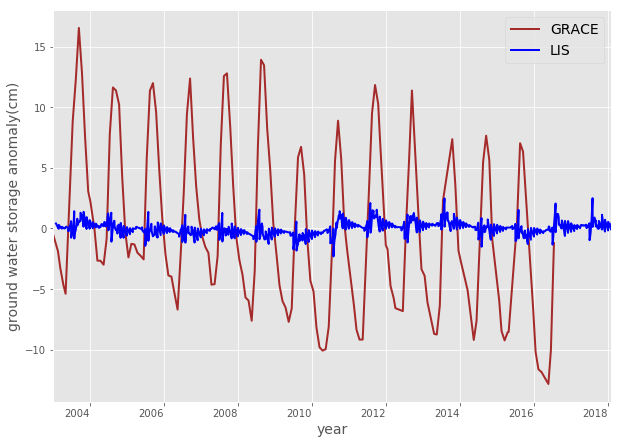

In [48]:
fig, ax = plt.subplots(1, figsize=(10, 8))
gok1.plot(ax=ax, y='cmwe', x='time',linewidth = 2,color='brown')
Aok.plot(ax=ax,y='GWS_tavg', x='date', linewidth = 2,color='blue') #x='date'
plt.ylabel('ground water storage anomaly(cm)', fontsize = 14)
plt.xlabel('year', fontsize = 14) #'year'
plt.xticks(rotation=0)
ax.legend(['GRACE','LIS'],fontsize = 14, loc = 1)
font = {'family' : 'Times',
        'size'   : 14}
matplotlib.rc('font', **font)

In [49]:
GRACE_mass = gok1.cmwe.values
GRACE_decyear = f['time']['yyyy_doy_yrplot_middle'][2, :]
LIS = Aok.GWS_tavg.values
LIS_dy1 = pd.Series(Aok.date).apply(lambda x: pyasl.decimalYear(x))

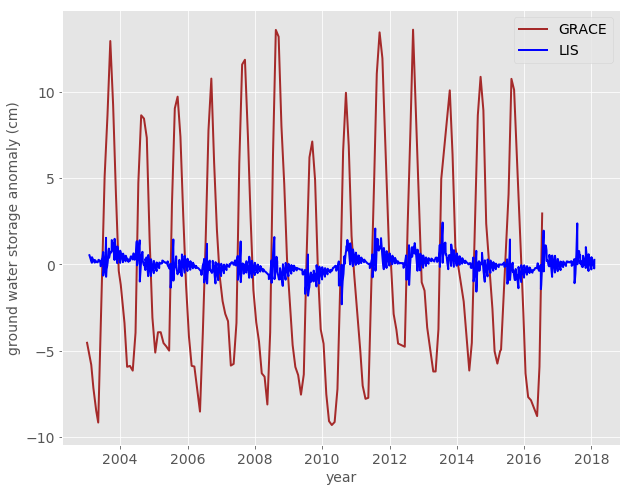

In [50]:
plt.figure(figsize=(10,8))
plt.plot(GRACE_decyear,signal.detrend(GRACE_mass, type = 'linear'),color='brown',linewidth = 2)
plt.plot(LIS_dy1,signal.detrend(LIS, type = 'linear'),color='blue',linewidth = 2)

plt.ylabel('ground water storage anomaly (cm)', fontsize = 14)
plt.xlabel('year', fontsize = 14)
plt.legend(['GRACE','LIS'],fontsize = 14, loc = 1)

font = {'family' : 'Times',
        'size'   : 14}

matplotlib.rc('font', **font)

In [51]:
t_grace=get_cmwe_trend_analysis(masked_gdf4, f)

In [52]:
t_grace_cl =gpd.overlay(shdf,t_grace, how='intersection')

In [109]:
#print(t_grace_cl)

Text(0.5, 55.92319665921714, 'longtitude')

<Figure size 864x576 with 0 Axes>

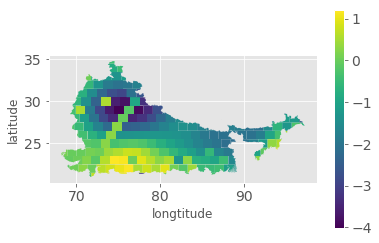

In [107]:
plt.figure(figsize=(12,8))
t_grace_cl.plot(column='avg_mass_change_cm',cmap='viridis', legend=True)
plt.ylabel('latitude', fontsize = 12)
plt.xlabel('longtitude', fontsize = 12)

### Calculate LIS GWSA trend

#### Convert the date from multiindex into date column

In [53]:
LISga = dfok4.reset_index()

In [113]:
#print(LISga)

### Calculate LIS GWSA trend per mascon

In [54]:
LIS_t=pd.DataFrame()
LIS_t['trend']=LISga.groupby('mascon').apply(lambda x: trend_analysis(x['date'].apply(lambda x: pyasl.decimalYear(x)), 
                                                   x['GWS_tavg'], optimization = True)[1] )

### Join the GWSA trend with mascon dataframe (get geometry)

In [55]:
mascon_t_g=t_grace_cl.join(LIS_t, on='mascon')

### Plot the spatial trend of each mascon for UGWA data

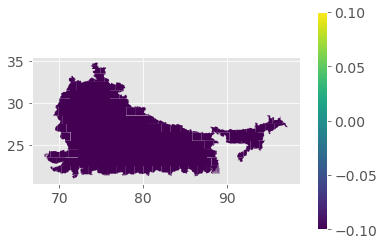

In [56]:
# WBM trend for indus basin
mascon_t_g.plot(column='trend',cmap='viridis', legend=True) 

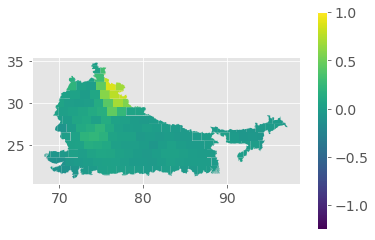

In [68]:
mascon_t_g.plot(column='trend',cmap='viridis',vmin=-1.25,vmax=1, legend=True) 